In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, train_test_split

## Read data - (1. dataset)

In [2]:
# load Ground Truth
df1 = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv')
df1.rename(columns={"updrs108": "updrs"}, inplace=True)
df1.drop('nqScore', axis=1, inplace=True)
df1.head()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1,file_2
0,11,True,14.25,NaN,162.25,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
1,60,False,2.00,NaN,162.25,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
2,67,True,25.25,NaN,133.75,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
3,68,False,6.00,NaN,159.00,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
4,70,True,26.25,NaN,113.50,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv


In [3]:
df1.shape

(31, 8)

In [3]:
print('Patients with PD: ', len(df1[df1['gt']==False]))
print('Patients without PD: ', len(df1[df1['gt']==True]))

Patients with PD:  13
Patients without PD:  18


In [4]:
# load Ground Truth
df2 = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv')
df2.rename(columns={"updrs108": "updrs"}, inplace=True)
df2.drop('nqScore', axis=1, inplace=True)
df2.head()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1
0,1000,True,27,79.0,184.5,56.866667,1424946827.1000_001_014.csv
1,1001,True,16,96.5,189.0,118.000000,1427279751.1001_001_014.csv
2,1002,False,5,140.0,158.0,119.037037,1426676689.1002_001_014.csv
3,1004,True,22,83.5,191.5,74.266667,1429866367.1004_001_014.csv
4,1005,True,17,68.0,150.0,74.969697,1430134526.1005_001_014.csv


In [6]:
print('Patients with PD: ', len(df2[df2['gt']==False]))
print('Patients without PD: ', len(df2[df2['gt']==True]))

Patients with PD:  30
Patients without PD:  24


In [5]:
df_conc = pd.concat([df1, df2], ignore_index=True)
df_conc.tail()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1,file_2
80,1063,False,0.0,110.0,170.0,109.800000,1463511198.1063_001_014.csv,NaN
81,1064,True,28.0,75.5,140.0,105.333333,1458723488.1064_001_014.csv,NaN
82,1066,True,12.0,118.0,170.5,140.250000,1460104760.1066_001_014.csv,NaN
83,1068,True,26.0,65.5,98.0,48.800000,1460559248.1068_001_014.csv,NaN
84,1070,False,2.0,126.0,154.5,54.933333,1463130212.1070_001_014.csv,NaN


Text(0.5, 0, 'Parkinson disease')

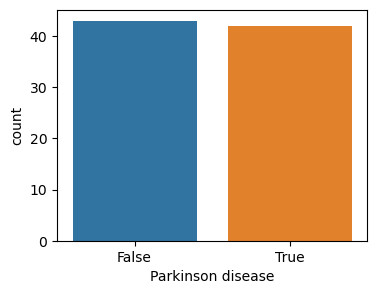

In [7]:
plt.figure(figsize=[4,3])
sns.countplot(x = 'gt', data = df_conc)
plt.xlabel('Parkinson disease')

In [6]:
# read example file
df_ID = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/data_MIT-CS2PD/'+ df2['file_1'][1], header = None, names=['pressedKey','holdTime', 'releaseTime', 'pressTime'])
df_ID.head()

,pressedKey,holdTime,releaseTime,pressTime
0,2,0.1135,1.4512,1.3377
1,parenright,0.1269,2.3214,2.1945
2,Shift_L,0.2064,2.3555,2.1491
3,space,0.1317,3.2163,3.0847
4,mouse_left,0.1001,6.7385,6.6384


In [22]:
df2['file_1'][1]

'1427279751.1001_001_014.csv'

In [7]:
df_ID['flightTime'] = df_ID['pressTime'] - \
    pd.concat([pd.Series(0), df_ID['releaseTime']], ignore_index=True)
df_ID.head()

,pressedKey,holdTime,releaseTime,pressTime,flightTime
0,2,0.1135,1.4512,1.3377,1.3377
1,parenright,0.1269,2.3214,2.1945,0.7433
2,Shift_L,0.2064,2.3555,2.1491,-0.1723
3,space,0.1317,3.2163,3.0847,0.7292
4,mouse_left,0.1001,6.7385,6.6384,3.4221


In [8]:
df_ID['latencyTime']=df_ID['flightTime']+pd.concat([pd.Series(0),df_ID['holdTime']],ignore_index=True)
df_ID.tail()

,pressedKey,holdTime,releaseTime,pressTime,flightTime,latencyTime
1744,Shift_L,0.3029,771.9147,771.6118,-0.2687,-0.1766
1745,Return,0.0978,774.1936,774.0958,2.1811,2.4840
1746,minus,0.0979,774.5318,774.4340,0.2404,0.3382
1747,space,0.1241,775.0568,774.9327,0.4009,0.4988
1748,Shift_L,0.6236,778.9472,778.3236,3.2668,3.3909


In [21]:
df_ID[df_ID['holdTime']>1]

,pressedKey,holdTime,releaseTime,pressTime,flightTime,latencyTime
6,s,1.427280e+09,7.8130,-1.427280e+09,-1.427280e+09,-1.427280e+09
21,s,1.427280e+09,30.2742,-1.427280e+09,-1.427280e+09,-1.427280e+09
126,e,1.427280e+09,81.1305,-1.427280e+09,-1.427280e+09,-1.427280e+09
262,s,1.427280e+09,132.3189,-1.427280e+09,-1.427280e+09,-1.427280e+09
535,p,1.427280e+09,239.9225,-1.427280e+09,-1.427280e+09,-1.427280e+09
620,s,1.427280e+09,268.2952,-1.427280e+09,-1.427280e+09,-1.427280e+09
626,O,1.427280e+09,270.2783,-1.427280e+09,-1.427280e+09,-1.427280e+09
632,o,2.407300e+00,272.5620,2.701548e+02,-2.145300e+00,-2.044000e+00
641,o,5.998200e+00,278.4862,2.724880e+02,-5.981900e+00,-5.833000e+00
656,o,3.473900e+00,281.8660,2.783921e+02,-3.460900e+00,-3.289900e+00


### Feature extraction - 1. approach  (1. dataset)

In [9]:
# https://www.nature.com/articles/srep34468

# to będzie potem w zapętleniu x razy, x - liczba blokow Bi
df_newtemp = df_ID[df_ID['releaseTime'] < 90]  # zakładana długość
Q1 = df_newtemp['holdTime'].quantile(q=0.25)
Q3 = df_newtemp['holdTime'].quantile(q=0.75)
IQR = Q3 - Q1
upper_lim = Q3 + 1.5*IQR
lower_lim = Q1 - 1.5*IQR
vout = len(df_newtemp[(df_newtemp['holdTime'] < lower_lim)
           | (df_newtemp['holdTime'] > upper_lim)])
viqr = (df_newtemp['holdTime'].quantile(q=0.5 - Q1))/(Q3 - Q1)
hist, bin_edges = np.histogram(df_newtemp['holdTime'], bins=4, density=True)
vhist1, vhist2, vhist3, vhist4 = hist * np.diff(bin_edges)
# vde - dla wszystkich i potem dodac czy jak?

### Feature extraction - 2. approach  (1. dataset)

395856181.1275291
0.1884906250037007
252309802.99168923
0.12344175414610191
0.037582541342930806
212766315.1667897
0.03170869273751208
0.034056513161356924
222903668.64138144
0.035358031195582035
0.034675735623424644
0.04184565705994261
0.02962114697607332
0.02950103265005066
0.029120608988561576
225672781.50103799
0.028223949501977857
228547714.44800773
217658162.66057494
2.216352570941675
1.6463155084787549
1.430293450913448
2.0914111460206968
1.779729890174421


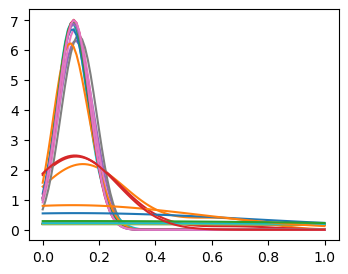

In [26]:
# https://www.nature.com/articles/s41598-018-25999-0

# 15-seconds non-overlapping time windows
assumed_length = 360  # first condition
window_time = 15  # time width of window
n_windows = int(assumed_length/window_time)

t_inter = np.arange(0, 1.01, 0.01)  # for KDE
stat_moments = np.zeros([4, n_windows])
data_for_cov= np.zeros([n_windows, len(t_inter)])
fig, axs = plt.subplots(figsize=[4, 3])

for i in range(n_windows):
    df_newtemp = df_ID[(df_ID['releaseTime'] > i*window_time)
                       & (df_ID['releaseTime'] < (i+1)*window_time)]

    # to normalize here only for FLIGHT TIME: zero-mean
    stat_moments[0, i] = df_newtemp['holdTime'].mean()       # first order
    stat_moments[1, i] = df_newtemp['holdTime'].std()        # second order
    stat_moments[2, i] = df_newtemp['holdTime'].kurtosis()   # third order
    stat_moments[3, i] = df_newtemp['holdTime'].skew()       # fourth order

    print(stat_moments[1, i])
    # PDF estimation via KDE
    X = df_newtemp['holdTime'].to_numpy().reshape(-1, 1)

    bandwidth = np.arange(0.05, 2, .1)
    kde = KernelDensity(kernel='gaussian')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(X)
    kde = grid.best_estimator_
    # czy nie sprzeczność? -> fitujemy na X a potem bierzemy score_samples

    # kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    log_density = np.exp(kde.score_samples(t_inter.reshape(-1, 1)))
    data_for_cov[i, :] = log_density
    axs.plot(t_inter, log_density)

va = np.zeros(11)
for i in range(4):
    va[i*2], va[i*2+1] = np.mean(stat_moments[i, :]
                                 ), np.std(stat_moments[i, :], ddof=1)

In [28]:
# covariance of PDFs
# the matrix of sample covariance C(i, j) between the PDFs of all subsequences
# kolejne samples to kolejne PDFy
# cov_matrix = np.cov()
# https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation
# https://stackabuse.com/kernel-density-estimation-in-python-using-scikit-learn/

a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# extract values only from upper triangle of matrix
upper_triangle = a[np.triu_indices_from(a)]
# or above the diagonal
upper_triangle = a[np.triu_indices_from(a, k=1)]

cov_matrix = np.cov(data_for_cov)
print(cov_matrix.shape)
upper_triangle = np.abs(cov_matrix[np.triu_indices_from(cov_matrix)])
va[8] = np.mean(upper_triangle)
va[9] = np.std(upper_triangle, ddof=1)
va[10] = np.sum(upper_triangle)

(24, 24)


In [22]:
# zagadnienie: jakie bandwidth w KDE?
# Tuning the Bandwidth Parameter

for i in list_KDE:
    df_newtemp = df_ID[(df_ID['releaseTime'] > i*window_time)
                       & (df_ID['releaseTime'] < (i+1)*window_time)]
    X = df_newtemp['holdTime'].to_numpy().reshape(-1, 1)

    # x_train, x_test = train_test_split(X, test_size=0.3, shuffle=True)
    bandwidth = np.arange(0.05, 2, .05)
    kde = KernelDensity(kernel='gaussian')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    # grid.fit(x_train)
    grid.fit(X)
    kde = grid.best_estimator_
    # log_dens = kde.score_samples(x_test)
    # plt.fill(x_test, np.exp(log_dens), c='green')
    # plt.title('Optimal estimate with Gaussian kernel')
    # plt.show()
    print("optimal bandwidth: " + "{:.2f}".format(kde.bandwidth))

optimal bandwidth: 1.95
optimal bandwidth: 1.95
optimal bandwidth: 0.05
optimal bandwidth: 0.05
optimal bandwidth: 1.95
optimal bandwidth: 0.05
optimal bandwidth: 0.05
optimal bandwidth: 0.05
optimal bandwidth: 0.05
optimal bandwidth: 0.05
optimal bandwidth: 1.95
optimal bandwidth: 0.05
optimal bandwidth: 1.95
optimal bandwidth: 1.95
optimal bandwidth: 1.75
optimal bandwidth: 0.65
optimal bandwidth: 0.45
optimal bandwidth: 0.15


In [28]:
# import nqDataLoader as nq
# pressedKey, holdTime, pressTime, releaseTime= nq.getDataFiltHelper('MIT-CS2PD/data_MIT-CS2PD/' + df2.loc[1]['file_1'])

## Read data - (2. dataset TAPPY)

In [ ]:
directory_path1 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Archived users/'
files_list1 = os.listdir(directory_path1)
data1 = pd.read_table(
    directory_path1 + files_list1[11], sep=': ', names=['Value'], engine='python')
data1

In [16]:
users = [el.split("_")[1].split(".")[0] for el in files_list1]
df_ID2 = pd.DataFrame(data=users, columns=['pID'])

directory_path2 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Tappy Data/'
files_list2 = os.listdir(directory_path2)

for i, el in enumerate(df_ID2['pID']):
    temp = [x for x in files_list2 if x.startswith(el)]
    if len(temp):
        df_ID2.loc[[i], 'files'] = pd.Series([temp], index=df_ID2.index[[i]])
        with open(directory_path1 + files_list1[i], 'r') as f:
            for line in f:
                if 'Parkinsons' in line:       
                    read_info = line.strip().split(": ")
                    df_ID2.loc[[i], 'Parkinsons'] = read_info[1]
                    
df_ID2.dropna(inplace=True)
df_ID2

,pID,files,Parkinsons
0,0EA27ICBLF,"[0EA27ICBLF_1607.txt, 0EA27ICBLF_1608.txt]",True
1,0QAZFRHQHW,"[0QAZFRHQHW_1609.txt, 0QAZFRHQHW_1610.txt]",False
3,1HOEBIGASW,[1HOEBIGASW_1702.txt],False
5,1XNJCXS3EY,[1XNJCXS3EY_1608.txt],False
6,2JTCBKUP8T,"[2JTCBKUP8T_1702.txt, 2JTCBKUP8T_1703.txt]",True
...,...,...,...
222,ZT9ASWFCFS,[ZT9ASWFCFS_1606.txt],True
223,ZWBPPNQCUX,"[ZWBPPNQCUX_1608.txt, ZWBPPNQCUX_1612.txt]",True
224,ZWHGXDUDLG,[ZWHGXDUDLG_1703.txt],True
225,ZY9CCHSPF2,"[ZY9CCHSPF2_1607.txt, ZY9CCHSPF2_1608.txt, ZY9...",True


Text(0.5, 0, 'Parkinson disease')

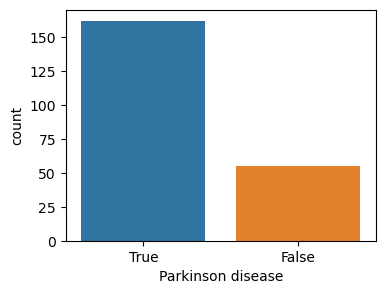

In [23]:
plt.figure(figsize=[4,3])
sns.countplot(x = 'Parkinsons', data = df_ID2)
plt.xlabel('Parkinson disease')

In [11]:
looking_str = files_list1[1].split("_")[1].split(".")[0]
looking_str

directory_path2 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Tappy Data/'
files_list2 = os.listdir(directory_path2)
results = [x for x in files_list2 if x.startswith(looking_str)]
results

['0QAZFRHQHW_1609.txt', '0QAZFRHQHW_1610.txt']

In [12]:
data2 = pd.read_table(directory_path2 + results[0], index_col=False, names=[
                      'User', 'Date', 'Timestamp', 'Hand', 'holdTime', 'Direction', 'flightTime', 'latencyTime', ])
data2.drop(columns=['User'], inplace=True)
data2

,Date,Timestamp,Hand,holdTime,Direction,flightTime,latencyTime
0,160916,19:20:43.891,L,78.1,LL,312.5,257.8
1,160916,19:20:44.344,L,78.1,LL,453.1,375.0
2,160916,19:20:44.742,L,62.5,LL,414.1,335.9
3,160916,19:20:45.516,L,93.8,LL,742.2,679.7
4,160916,19:20:46.047,R,101.6,LR,523.4,429.7
...,...,...,...,...,...,...,...
819,160930,09:32:11.242,R,78.1,RR,234.4,109.4
820,160930,09:32:13.555,R,156.3,LR,558.6,484.4
821,160930,14:09:36.102,L,78.1,LL,476.6,359.4
822,160930,21:51:49.695,L,93.8,LL,453.1,351.6


In [15]:
grouped_data = data2.groupby('Date').agg(list)
grouped_data['Length'] = grouped_data['Timestamp'].apply(len) 
grouped_data

,Timestamp,Hand,holdTime,Direction,flightTime,latencyTime,Length
Date,,,,,,,
160916,"[19:20:43.891, 19:20:44.344, 19:20:44.742, 19:...","[L, L, L, L, R, R]","[78.1, 78.1, 62.5, 93.8, 101.6, 93.8]","[LL, LL, LL, LL, LR, RR]","[312.5, 453.1, 414.1, 742.2, 523.4, 203.1]","[257.8, 375.0, 335.9, 679.7, 429.7, 101.6]",6
160918,"[10:35:01.508, 10:35:01.930, 10:35:02.164, 10:...","[L, R, R, L, R, R, R, R, L, L, L, R, R, L, R, ...","[109.4, 214.8, 66.4, 93.8, 187.5, 109.4, 156.3...","[RL, LR, RR, RL, RR, RR, LR, RR, LL, LL, LL, L...","[289.1, 316.4, 382.8, 562.5, 453.1, 265.6, 515...","[175.8, 207.0, 168.0, 390.6, 281.3, 78.1, 437....",80
160919,"[18:39:21.977, 18:39:22.477, 18:39:22.922, 21:...","[L, L, L, R, L, L, R, L, R, L, R, L, L, R]","[78.1, 70.3, 78.1, 171.9, 132.8, 140.6, 132.8,...","[LL, LL, LL, RR, RL, LL, LR, RL, LR, RL, LR, R...","[421.9, 507.8, 437.5, 406.3, 304.7, 695.3, 476...","[343.8, 429.7, 367.2, 289.1, 195.3, 562.5, 335...",14
160921,"[16:34:25.703, 16:34:27.164, 16:45:29.914, 16:...","[L, L, L, L, R, L, L, L]","[93.8, 109.4, 125.0, 140.6, 121.1, 101.6, 117....","[LL, LL, RL, LL, LR, RL, LL, LL]","[453.1, 511.7, 335.9, 355.5, 496.1, 796.9, 464...","[343.8, 418.0, 226.6, 214.8, 355.5, 675.8, 363...",8
160922,"[08:40:36.512, 08:40:37.027, 08:40:37.402, 08:...","[L, L, L, R, L, L, L, R, R, R, L, L, L, R, R, ...","[78.1, 78.1, 62.5, 105.5, 93.8, 97.7, 101.6, 1...","[LL, LL, LL, RR, SL, LL, LL, LR, RR, SR, RL, L...","[359.4, 515.6, 390.6, 203.1, 382.8, 214.8, 203...","[281.3, 437.5, 312.5, 125.0, 234.4, 121.1, 109...",559
160923,"[15:54:36.141, 15:54:36.688, 15:54:36.938, 15:...","[L, L, L, L, R, R, L, R, L, S, R, R, L, R, L, ...","[93.8, 93.8, 93.8, 109.4, 93.8, 78.1, 31.3, 10...","[LL, LL, LL, LL, LR, RR, RL, SR, RL, LS, RR, R...","[187.5, 546.9, 250.0, 781.3, 546.9, 187.5, 484...","[93.8, 453.1, 156.3, 687.5, 437.5, 93.8, 414.1...",51
160925,"[09:04:27.662, 09:04:29.318]","[L, L]","[121.1, 146.5]","[LL, LL]","[404.3, 634.8]","[347.7, 507.8]",2
160926,"[14:19:25.395, 14:19:26.031, 14:19:26.680, 14:...","[L, R, L, R, L, L, L, R, R, L, L, R, R]","[105.5, 152.3, 82.0, 136.7, 148.4, 179.7, 164....","[RL, LR, RL, LR, LL, LL, LL, LR, RR, LL, LL, L...","[546.9, 589.8, 718.8, 710.9, 355.5, 722.7, 406...","[414.1, 484.4, 566.4, 628.9, 187.5, 574.2, 226...",13
160927,"[13:47:29.781, 13:47:31.344, 19:24:13.188, 19:...","[L, L, L, R, R, R, L, R, R, R, L, R, R, L, R, ...","[93.8, 156.3, 164.1, 117.2, 132.8, 132.8, 140....","[LL, LL, RL, LR, RR, RR, RL, LR, RR, LR, RL, L...","[441.4, 441.4, 218.8, 437.5, 703.1, 234.4, 539...","[328.1, 328.1, 109.4, 273.4, 585.9, 101.6, 406...",30


In [25]:
idx=grouped_data['Length'].idxmax()
new_rec=data2[data2['Date']==idx]
print(new_rec)

       Date     Timestamp Hand  holdTime Direction  flightTime  latencyTime
108  160922  08:40:36.512    L      78.1        LL       359.4        281.3
109  160922  08:40:37.027    L      78.1        LL       515.6        437.5
110  160922  08:40:37.402    L      62.5        LL       390.6        312.5
111  160922  08:40:57.775    R     105.5        RR       203.1        125.0
112  160922  14:15:30.012    L      93.8        SL       382.8        234.4
..      ...           ...  ...       ...       ...         ...          ...
662  160922  22:36:15.094    R     109.4        LR       218.8         62.5
663  160922  22:36:16.766    R      78.1        RR       187.5        125.0
664  160922  22:36:19.953    L     140.6        RL       609.4        515.6
665  160922  22:36:20.312    R      93.8        LR       406.3        265.6
666  160922  22:36:20.820    R      78.1        RR       523.4        429.7

[559 rows x 7 columns]
